In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
import user_functions as uf 
uf.korean()

# default_path = "../lab10/raw_data/"
# app_train = pd.read_csv(default_path+"application_train.csv")

data = pd.read_csv('../../pjt2/raw_data/train_datasets.csv')

In [3]:
y_target = data[['TARGET']]
X_features = data.drop(columns=['Unnamed: 0','SK_ID_CURR','TARGET'])
y_target

,TARGET
0,1.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
303839,0.0
303840,0.0
303841,0.0
303842,1.0


In [5]:
X_features.describe()

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_EDUCATION_TYPE,REGION_POPULATION_RELATIVE,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
count,303844.000000,303844.000000,303844.000000,303844.000000,3.038440e+05,3.038440e+05,303844.000000,3.038440e+05,303844.000000,303844.000000,...,303844.000000,303844.000000,303844.000000,303844.000000,303844.000000,303844.000000,303844.00000,303844.000000,303844.000000,303844.000000
mean,0.093229,0.340467,0.693909,0.418083,1.682433e+05,5.983631e+05,27079.108981,4.850558e+05,3.192908,0.020817,...,0.000207,0.000158,0.002047,0.025437,0.000648,0.007181,0.00389,0.017529,0.004315,0.180208
std,0.290753,0.473867,0.460869,0.718155,1.101528e+05,4.009837e+05,14392.409533,2.835343e+05,1.296352,0.013780,...,0.014398,0.012568,0.045199,0.157450,0.025455,0.084438,0.06225,0.131231,0.065545,0.384361
min,0.000000,0.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000000,0.000290,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.125000e+05,2.700000e+05,16551.000000,2.385000e+05,2.000000,0.010006,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,1.478182e+05,5.135310e+05,24907.500000,4.500000e+05,4.000000,0.018850,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,1.000000,2.025000e+05,8.086500e+05,34587.000000,6.750000e+05,4.000000,0.028663,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,5.000000,1.800009e+07,4.050000e+06,258025.500000,1.336500e+06,4.000000,0.072508,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000


<AxesSubplot:>

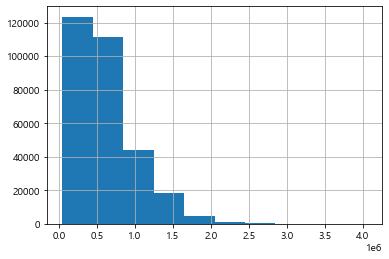

In [7]:
X_features['AMT_CREDIT'].hist()

<AxesSubplot:>

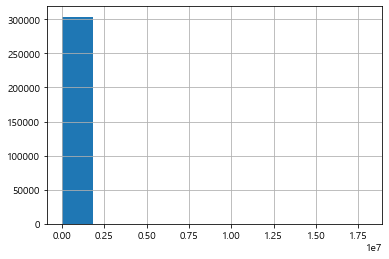

In [9]:
X_features['AMT_INCOME_TOTAL'].hist()

In [84]:
# base modeling 함수

# (1)단일 모델의 RMSE 값 반환
def get_rmse(model): # 학습된 모델을 받아서 예측하고 RMSE 반환
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    
    print('{0}  RMSE :{1}'.format(model.__class__.__name__, np.round(rmse, 3)))
    return rmse


# 여러 모델의 RMSE 값 반환
def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)

    return rmses
#-------------------------------------------------------------------------------------------------
# (2) 피처 수가 많으므로 회기 계수값의 
# 상위 10개, 하위 10개 (-값으로 가장 큰 10개)의
# 피처명과 회귀 계수값을 가지는 Series 반환하는 함수 생성
def get_top_bottom_coef(model):
    # coef_ 속성을 기반으로 Series 객체 생성
    # 회기 계수와 피처명를 가짐
    # index는 칼럼명(피처명)
    coef = pd.Series(model.coef_, index=X_features.columns)
    
    # + 상위 10개, - 하위 10개 회귀 계수 추출하여 반환
    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)
    
    return coef_high, coef_low
#-------------------------------------------------------------------------------------------------
# (3) 모델별 회귀 계수 시각화 함수
# list 객체로 모델을 입력 받아서
# 모델별로 회귀 계수 상위 10개, 하위 10개 추출해서
# 가로 막대 그래프 형태로 출력

def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=3)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 회귀 계수 시각화. 
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합. 
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat( [coef_high , coef_low] )
        
        # 순차적으로 ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정. 
        axs[i_num].set_title(model.__class__.__name__ +' Coeffiecents', size=25)
        axs[i_num].tick_params(axis="y",direction="in", pad=-120) # 안쪽, 패딩값
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=axs[i_num])
#-------------------------------------------------------------------------------------------------
# (4) 폴드 교차 검증으로 모델별 RMSE와 평균 RMSE 출력
from sklearn.model_selection import cross_val_score

def gt_avg_rmse_cv(models):
    for model in models:
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target, scoring="neg_mean_squared_error", cv = 5))
        rmse_avg = np.mean(rmse_list)

        print('\n{0} CV RMSE 값 리스트 :{1}'.format(model.__class__.__name__, np.round(rmse_list, 3)))
        print('{0} CV 평균 RMSE 값 :{1}'.format(model.__class__.__name__, np.round(rmse_avg, 3)))
    
# lr_reg, ridge_reg, lasso_reg 모델의 CV RMSE 값 출력
#-------------------------------------------------------------------------------------------------
# 모델과 하이퍼 파라미터값을 전달 받아서
# 최적화 작업의 결과를 표시하는 함수 작성
# 릿지와 라쏘 모델의 최적화 alpha 값 추출
from sklearn.model_selection import GridSearchCV
def get_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    
    rmse = np.sqrt(-1*grid_model.best_score_)
    
    print('{0} 5 CV 시 최적 평균 RMSE 값 :{1}, 최적 alpha {2}'.format(model.__class__.__name__, 
                                                                np.round(rmse, 4),
                                                               grid_model.best_params_))
    
    return grid_model.best_estimator_
#-------------------------------------------------------------------------------------------------

In [85]:
# 학습/테스트 데이터 세트 분리
X_train , X_test , y_train , y_test = train_test_split(X_features , y_target, test_size=0.2, random_state=156)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)


LinearRegression  RMSE :0.264
Ridge  RMSE :0.264
Lasso  RMSE :0.271


[0.26439812383015165, 0.26439438750769206, 0.2710513828829011]

In [86]:
# X_train : 243075 rows × 142 columns
# X_test : 60769 rows × 142 columns
# y_train : 243075 rows × 1 columns
# y_test : 60769 rows × 1 columns

In [87]:
get_top_bottom_coef(lasso_reg)

(DAYS_ID_PUBLISH           5.257101e-06
 DAYS_BIRTH                4.065448e-06
 DAYS_REGISTRATION         1.348314e-06
 AMT_ANNUITY               4.312432e-07
 AMT_CREDIT_SUM_OVERDUE    1.740602e-07
 연체기간(pos_cash)            1.685100e-07
 DAYS_EMPLOYED             7.275316e-09
 AMT_CREDIT_SUM_DEBT       2.265089e-09
 AMT_CREDIT_MAX_OVERDUE    2.199618e-09
 AMT_ANNUITY(bure)         9.924750e-10
 dtype: float64,
 NAME_INCOME_TYPE_State servant      -0.000000e+00
 NAME_INCOME_TYPE_Student            -0.000000e+00
 NAME_INCOME_TYPE_Unemployed          0.000000e+00
 NAME_INCOME_TYPE_Working             0.000000e+00
 NAME_FAMILY_STATUS_Civil marriage    0.000000e+00
 ORGANIZATION_TYPE_XNA               -0.000000e+00
 AMT_CREDIT_SUM                      -1.435739e-09
 AMT_GOODS_PRICE                     -1.916384e-09
 AMT_CREDIT                          -2.376261e-08
 AMT_INCOME_TOTAL                    -3.833330e-08
 dtype: float64)

In [88]:
models = [lr_reg, ridge_reg, lasso_reg]    
gt_avg_rmse_cv(models)


LinearRegression CV RMSE 값 리스트 :[0.263 0.267 0.265 0.263 0.262]
LinearRegression CV 평균 RMSE 값 :0.264

Ridge CV RMSE 값 리스트 :[0.263 0.267 0.265 0.263 0.262]
Ridge CV 평균 RMSE 값 :0.264

Lasso CV RMSE 값 리스트 :[0.27  0.274 0.271 0.27  0.269]
Lasso CV 평균 RMSE 값 :0.271


In [89]:
# 학습/테스트 데이터 세트 분리
X_train , X_test , y_train , y_test = train_test_split(X_features , y_target, test_size=0.2, random_state=156)

# model 변수 선언
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

# 릿지와 라쏘 모델의 최적 alpha 값 확인
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}

best_ridge = get_best_params(ridge_reg, ridge_params)
best_lasso = get_best_params(lasso_reg, lasso_params)


Ridge 5 CV 시 최적 평균 RMSE 값 :0.2642, 최적 alpha {'alpha': 0.1}
Lasso 5 CV 시 최적 평균 RMSE 값 :0.2648, 최적 alpha {'alpha': 0.001}


In [36]:
# 앞의 최적화 alpha 값으로 학습 데이터로 학습, 테스트 데이터로 예측 및 평가 수행
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge(alpha= 0.1)
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso(alpha= 0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models) # 학습된 모델 전달하고 RMSE 출력


LinearRegression  RMSE :0.264
Ridge  RMSE :0.264
Lasso  RMSE :0.265


[0.26439812383015165, 0.2643844972947902, 0.2650528757055595]

### XGBoost와 LightGBM 이용해서 학습/예측/평가 수행

In [43]:
# (1) XGBoost
from xgboost import XGBRegressor

xgb_params = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
best_xgb = get_best_params(xgb_reg, xgb_params)

XGBRegressor 5 CV 시 최적 평균 RMSE 값 :0.2598, 최적 alpha {'n_estimators': 1000}


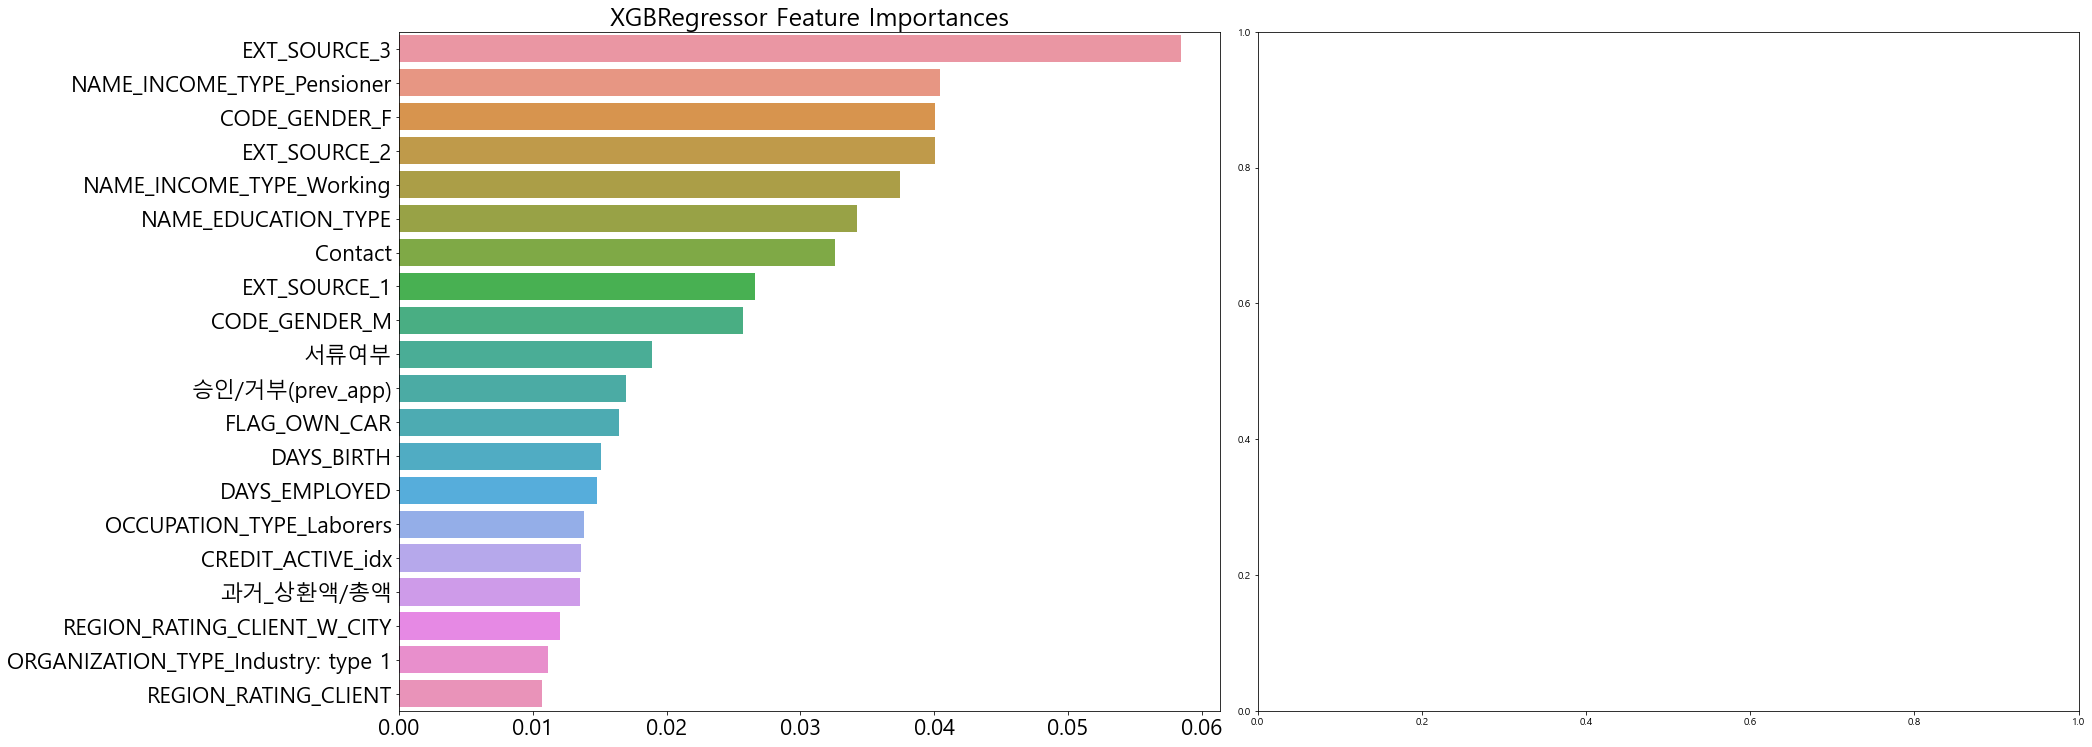

In [104]:
orean()
def get_top_features(model):
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=X_features.columns  )
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
    return ftr_top20

def visualize_ftr_importances(models)2
    # 1개 회귀 모델의 2각화를 위해 1개의 컬럼을 가지는 su ncols=2
    fig, axs = plt.subplots(figsize=(24,101,nrows=12 ncols=1)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 피처 중요도 시각화. 
    for i_num, model in enumerate(models):
        # 중요도 상위 20개의 피처명과 그때의 중요도값 추출 
        ftr_top20 = get_top_features(model)
        axs[i_num].set_title(model.__class__.__name__+' Feature Importances', size=25)
        #font 크기 조정.
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=ftr_top20.values, y=ftr_top20.index , ax=axs[i_num])

# 앞에서 get_best_params() 가 반환한 GridSearchCV 최적화된 모델 사용
models = [best_xgb]
visualize_ftr_importances(models)

In [100]:
# XGBoost feature importance '0'인 list
best_xgb.feature_importances_
xgb_ftr_importances = pd.DataFrame({'feature': list(X_features.columns), 'importance': best_xgb.feature_importances_}).sort_values('importance', ascending = False)

xgb_zero_features = list(xgb_ftr_importances[xgb_ftr_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(xgb_zero_features))
xgb_ftr_importances.tail(10)

There are 10 features with 0.0 importance


,feature,importance
50,NAME_INCOME_TYPE_Businessman,0.0
51,NAME_INCOME_TYPE_Commercial associate,0.0
46,NAME_TYPE_SUITE_Other_A,0.0
111,ORGANIZATION_TYPE_Insurance,0.0
54,NAME_INCOME_TYPE_Student,0.0
108,ORGANIZATION_TYPE_Industry: type 6,0.0
77,OCCUPATION_TYPE_Managers,0.0
100,ORGANIZATION_TYPE_Industry: type 10,0.0
121,ORGANIZATION_TYPE_Religion,0.0
141,ORGANIZATION_TYPE_XNA,0.0


In [92]:
print(xgb_zero_features)

['NAME_INCOME_TYPE_Businessman', 'NAME_INCOME_TYPE_Commercial associate', 'NAME_TYPE_SUITE_Other_A', 'ORGANIZATION_TYPE_Insurance', 'NAME_INCOME_TYPE_Student', 'ORGANIZATION_TYPE_Industry: type 6', 'OCCUPATION_TYPE_Managers', 'ORGANIZATION_TYPE_Industry: type 10', 'ORGANIZATION_TYPE_Religion', 'ORGANIZATION_TYPE_XNA']


In [47]:

# LightGBMError: Do not support special JSON characters in feature name.
# 위와 같은 에러로 아래와 같이 feature name내 특수문자 대체

# import re
# X_features = X_features.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
# X_train , X_test , y_train , y_test = train_test_split(X_features , y_target, test_size=0.2, random_state=156)

In [48]:
# (2) LightGBM
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, colsample_bytree=0.4, subsample=0.6, reg_lambda=10, n_jobs=-1)
best_lgmb = get_best_params(lgbm_reg, lgbm_params)

LightGBMError: Feature () appears more than one time.